# Assignment 5 - Domenico Profumo 533695

### IMPORT LIBRARIES

inizio importando le principali librerie che mi serviranno per gestire il codice

In [1]:
import cv2                                                  #for SIFT
import os                                                   #for read file system
import matplotlib.pyplot as plt                             #for plot and show images
import numpy as np                                          #for math computations
import pandas as pd                                         #for create structure of confusion matrix

from sklearn.cluster import KMeans                          #Clustering
from sklearn.metrics import accuracy_score,silhouette_score,confusion_matrix  #two metrics (accuracy, silhouette, confusion_matrix) 
from sklearn.preprocessing import MinMaxScaler, StandardScaler # two type of normalization

### DATA PROCESSING

imposto la cartella contenente le immagini e vado a contare il numero di elementi al suo interno

In [2]:
path = "image/"

cont=0

for file in os.listdir(path):
    if(file!=".ipynb_checkpoints"):
#        print(file)
        cont+=1

print("images number:",cont,"\n")

images number: 4 



adesso definisco una funzione che mi aiuterà a leggere una singola immagine, impostare il colore a grigio e successivamente tramite SIFT mi va ad estrarre i descrittori e i keypoints associati restituendo la coppia 
(image_with_keypoints,descriptors)

In [3]:
def read_and_compute(image_name):
    
    #reading image and set color Gray
    img = cv2.imread(image_name)  
    color = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #descriptors extraction
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img,None)
    img_1 = cv2.drawKeypoints(color,keypoints,img)
    return img_1, descriptors


definisco un ciclo in cui vado ad estrarre ogni tipo di immagine, in particolare dalle 8 tematiche principali, faccio in modo da prendere i temi collegati alle seguenti figure:

 - 1 -> Cows
 - 6 -> Face
 - 7 -> Car
 - 8 -> Bicycle
 
inoltre utilizzo le seguenti strutture per salvarmi tutte le componenti necessarie:

 - data_label: stores a index for each label (0->Cows, 1->Face, 2->Car, 3->Bicicle) and its used for mapping of each descriptor with their label
 - image_set: each position contains the image with the associated keypoints
 - descriptors_set: contains for each position an array with all associated descriptors 

In [4]:
data_label = []
image_set = []
descriptors_set = []

for file in os.listdir(path):
    if(file!=".ipynb_checkpoints"):
        source=path+file

        #if the file represents a Cows 
        if file[:1]=='1':
            im, de = read_and_compute(source)
            image_set.append(im)
            descriptors_set.append(de)
            for j in range(0,len(de)):
                data_label.append(0)

        #if the file represents a Human Face  
        if file[:1]=='6':
            im, de = read_and_compute(source)
            image_set.append(im)
            descriptors_set.append(de)
            for j in range(0,len(de)):
                data_label.append(1)

        #if the file represents Car
        if file[:1]=='7':
            im, de = read_and_compute(source)
            image_set.append(im)
            descriptors_set.append(de)
            for j in range(0,len(de)):
                data_label.append(2)

         #if the file represents Bicicle
        if file[:1]=='8':
            im, de = read_and_compute(source)
            image_set.append(im)
            descriptors_set.append(de)
            for j in range(0,len(de)):
                data_label.append(3)
                

In [5]:
print("Number of image analyzed:\t", len(image_set))
print("Total set of descriptors:\t", len(descriptors_set))
print("Total descriptors:\t\t", len(data_label))

Number of image analyzed:	 4
Total set of descriptors:	 4
Total descriptors:		 2090


vediamo un pò di immagini come esempio con i relativi descrittori associati..

#### Bicicle

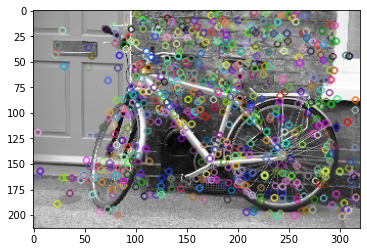

In [6]:
plt.imshow(image_set[0])

#### Car

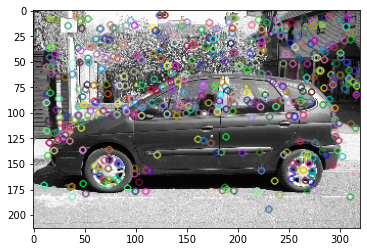

In [7]:
plt.imshow(image_set[1])

#### Face

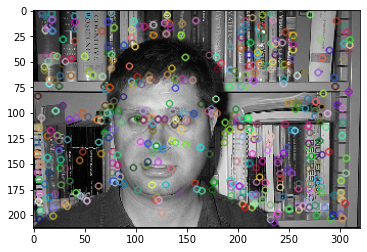

In [8]:
plt.imshow(image_set[2])

#### Cow

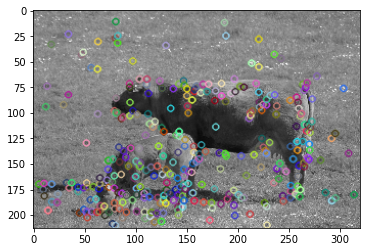

In [9]:
plt.imshow(image_set[3])

### Trasform descriptor_set

In [10]:
descriptors_set

[array([[ 0.,  1., 19., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 14.,  0.,  0.],
        [88., 23.,  5., ...,  0.,  0.,  0.],
        ...,
        [ 1.,  0.,  0., ...,  0.,  1., 26.],
        [24.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  1., ..., 12.,  1.,  0.]], dtype=float32),
 array([[ 4.,  0.,  0., ...,  0.,  2.,  9.],
        [ 1., 27., 40., ...,  4.,  1.,  2.],
        [24.,  6.,  0., ...,  1.,  4.,  3.],
        ...,
        [22., 18.,  8., ...,  0.,  0.,  0.],
        [23.,  2.,  0., ...,  0.,  0.,  0.],
        [25.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([[  0.,   0.,   0., ...,   3.,   0.,   6.],
        [ 49.,   2.,   2., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,  18.,  16.,  26.],
        ...,
        [  1.,   5.,   6., ...,   0.,   0.,   0.],
        [ 31.,  53., 114., ...,   8.,   1.,   1.],
        [  7.,   6.,   1., ...,  68.,  59.,   1.]], dtype=float32),
 array([[ 3.,  4., 68., ...,  0.,  2., 34.],
        [ 2.,  1., 

dato che descriptor_set è un array di 4 elementi in cui ogni elemento ha al suo interno un array che rappresenta uno specifico descrittore, quindi in totale abbiamo num_image*num_descrittori_immagine*valori_descrittore vogliamo fare in modo di trasformarlo in una matrice in cui abbiamo in una riga il singolo descrittore con il relativo valore associato

NOTA: ogni descrittore ha lo stesso numero di colonne (128), mentre il numero di descrittori per ciascuna immagine può variare

In [11]:
desc=np.vstack(descriptors_set)

np.shape(desc)

(2090, 128)

## K-Means

prima di eseguire il clustering eseguo la normalizzazione dei dati utilizzando la funzione MinMaxScale

In [12]:
data=desc

scaler = MinMaxScaler()
data = scaler.fit_transform(desc)

np.shape(data)

(2090, 128)

eseguo il clustering utilizzando il KMeans e impostando un numero di cluster uguale a 100. L'utilizzo del Kmeans è stato scelto per la sua caratteristica correllata al numero di centroidi in modo da riuscire ad associare ciascun descrittore ad un cluster specifico per valutare successivamente quanto è accurata questa "associazione" da gruppi di descrittori diversi

In [13]:
kmeans = KMeans(100)
kmeans.fit(data)

KMeans(n_clusters=100)

controllo che la dimensione dei label associati dal mio cluster sia la stessa del numero di righe perchè voglio ottenere un label per ogni descrittore della mia matrice

In [14]:
# find labels associati ad ogni descrittore
cluster_labels = kmeans.predict(data)
cluster_labels.shape

(2090,)

adesso cluster_labels conterà per ogni descrittore il valore che è stato associato a quest'ultimo

In [15]:
cluster_labels[2]

93

In [16]:
#associazioni 
print(len(cluster_labels))
print(len(data_label))

2090
2090


conto quanti cluster ho anche se lo so già

In [17]:
np.unique(cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32)

metto a 1 le posizioni degli elementi che contengono quel particolare cluster ad esempio metto la posizione a 1
    np.where(clusters == 22,1,0) mi restituisce un array 2090  

In [18]:
index = np.where(cluster_labels == 22,1,0)
len(index)

2090

[0 1 0 1 0 0 0 0 0 ] -> array dove 1 segna i descrittori che sono associati al cluster 22 nel mio caso
    da qui 

In [19]:
index

array([0, 0, 0, ..., 0, 0, 0])

mi conto quanti elementi ho

In [20]:
np.bincount(index)

array([2072,   18])

in questo caso nel cluster 22 ho 36 elementi(descrittori) all'interno, mi salvo l'indice di ciascuno di questi descrittori

In [21]:
indices = [index1 for index1, element in enumerate(index) if element == 1]
len(indices)

18

per ogni descrittore prendo il label che gli avevo associato e lo salvo in un array

In [22]:
somma=[]

for l in indices:    
#    print("indice riga del descrittore: ", l ,"----> labels associato:" , data_label[l])
    somma.append(data_label[l])

conto il label che compare maggiormente all'interno

In [23]:
np.bincount(somma).argmax()

1

mi salvo adesso in un dizionario l'indice del cluster associato, nel nostro esempio era 22, il label che è più presente all'interno


In [24]:
reference_label = {} 
num=np.bincount(somma).argmax()
reference_label[0] = num
reference_label

{0: 1}

adesso inizializzo un array avente come dimensione il numero di descrittori presenti 

In [25]:
len(cluster_labels)

2090

In [26]:
temp_labels = np.random.rand(len(cluster_labels))
temp_labels

array([0.36225372, 0.45791919, 0.47648035, ..., 0.81923766, 0.44380356,
       0.00967774])

mi prendo il cluster che è associato al primo descrittore 

In [27]:
cluster_labels[0]

41

ed utilizzo questo indice per trovarmi nel dizionario il cluster di riferimento

In [28]:
temp=0 #clusters[0]
for i in range(len(cluster_labels)):
        temp_labels[0] = reference_label[temp]
print(temp_labels[0])

1.0


in questo caso ho preso il riferimento del label associato al cluster 0 e l'ho salvato in temp.

Quello che ottengo sono due array:

    -   temp_labels (in cui ad ogni descrittore ho il label associato dal kmeans)
    -   data_labels (in cui ho i label effettivi di ogni descrittore)
   
a questo punto vado a confrontare il label che è stato associato dal kmeans (label che compariva maggiormente nel cluster) con quello che il realtà è il label del cluster effettivo 

## FUNCTION

funzione che presi in input il numero di labels trovati tramite kmeans e i label effettivi, mi crea un array dove ogni indice rappresenta il cluster associato (dal kmeans) a quel particolare descrittore e per ogni cluster prendo il label che compare magiormente. Alla fine restituisco un array con la stessa dimensione del numero di descrittori contenente al suo interno il valore del label che compare maggiormente nel cluster che gli è stato associato dal kmeans.

In [29]:
dictionary_index_label = {}

def get_kmeans_label(kmeans_label,data_label):
    
    for i in range(len(np.unique(kmeans_label))):
        # metto a 1 le posizioni degli elementi che contengono quel particolare cluster 
        index = np.where(kmeans_label == i,1,0)
        
        #mi prendo gli indici degli elementi associati ai cluster
        indices = [index1 for index1, element in enumerate(index) if element == 1]
        
        #mi salvo in un array tutti i label associati ai descrittori di quel particolare cluster
        somma = []
        for l in indices:
            somma.append(data_label[l])
            
        #conto il label che compare maggiormente (sarà la mia etichetta di riferiemnto)
        num=np.bincount(somma).argmax()
        
        #mi salvo nel dizionario che alla posizione del cluster i corrisponde il label trovato prima
        dictionary_index_label[i] = num
    
    #reference_label sarà il mio dizionario con i label e i cluster
    
    #temp_labels mi salva per ogni posizione del cluster il label che compare maggiormente
    #simple random inizialization
    predicted_labels = np.random.rand(len(kmeans_label))
    for i in range(len(kmeans_label)):
        predicted_labels[i] = dictionary_index_label[kmeans_label[i]]
    return predicted_labels


#alla fine restituirò un array contenente i label per ogni cluster

Quello che ottengo sono due array:

    -   predicted_labels (in cui ad ogni descrittore ho il label associato dal kmeans)
    -   data_label (in cui ho i label effettivi di ogni descrittore)
   
a questo punto vado a confrontare il label che è stato associato dal kmeans (label che compariva maggiormente nel cluster) con quello che il realtà è il label del cluster effettivo 

In [30]:
predicted_labels = get_kmeans_label(cluster_labels,data_label)

print("accuratezza nella classificazione:", accuracy_score(predicted_labels,data_label))

cmtx = pd.DataFrame(
    confusion_matrix(predicted_labels, data_label, labels=[0, 1, 2, 3]), 
    index=['Cow', 'Face','Car','Bicicle'], 
    columns=['Cow', 'Face','Car','Bicicle']
)

print(cmtx)
#matrice 4x4 in cui avremo per ogni riga un label (predetti e reali)
print("\n",confusion_matrix(predicted_labels, data_label))

accuratezza nella classificazione: 0.45454545454545453
         Cow  Face  Car  Bicicle
Cow      140    57   73       71
Face      74   247  136      125
Car       72    68  165       74
Bicicle  108   129  153      398

 [[140  57  73  71]
 [ 74 247 136 125]
 [ 72  68 165  74]
 [108 129 153 398]]


### Find best k and accuracy

#### Elbow method and Silouette score

Accuracy for k = {k}:  0.3196172248803828
Silouette for k = {k}:  0.07765117
------------------------------------------
Accuracy for k = {k}:  0.3411483253588517
Silouette for k = {k}:  0.05987176
------------------------------------------
Accuracy for k = {k}:  0.7516746411483254
Silouette for k = {k}:  0.042348593
------------------------------------------
Accuracy for k = {k}:  0.9904306220095693
Silouette for k = {k}:  0.020583719
------------------------------------------


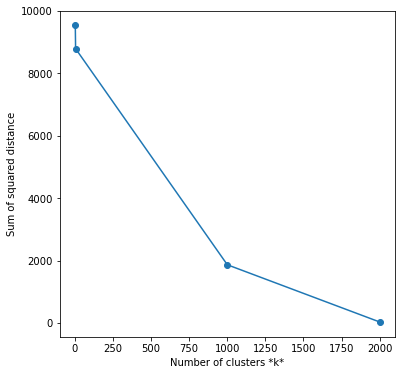

In [32]:
sse = []
#list_k = [2,8,12,20,40,100,500,1024,2048]
list_k = [2,4,1000,2000]
for k in list_k:
    km = KMeans(n_clusters=k)
    cluster_labels = km.fit_predict(data)
    #salvo la distanza dei punti dal cluster
    sse.append(km.inertia_)
    predicted_labels = get_kmeans_label(cluster_labels,data_label)
    print("Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))
    print("Silouette for k = {k}: ",(silhouette_score(data, km.labels_, metric='euclidean')))
    print("------------------------------------------")
    
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Final Result

In [33]:
cmtx = pd.DataFrame(
    confusion_matrix(predicted_labels, data_label, labels=[0, 1, 2, 3]), 
    index=['Cow', 'Face','Car','Bicicle'], 
    columns=['Cow', 'Face','Car','Bicicle']
)
print("\t TRUE/PREDICTED\n")
print(cmtx)

	 TRUE/PREDICTED

         Cow  Face  Car  Bicicle
Cow      394     0    0        1
Face       0   498    1        4
Car        0     1  523        8
Bicicle    0     2    3      655


## Personal Consideration

Discuss your findings. 

Choice of the number of clusters and of the clustering algorithm is on you (and should be discussed in the report).